In [1]:
# making all essential imports
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import re
import tensorflow as tf
import torch
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Input
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the dataset (i.e. simplified-recipes-1M.npz) and preprocessing to get a list of recipe lists as text
with np.load('simplified-recipes-1M.npz', allow_pickle=True) as data:
  recipes = data['recipes']
  ingredients = data['ingredients']

recipes = [[ingredients[i] for i in recipe] for recipe in recipes]

recipes

[['basil leaves',
  'focaccia',
  'leaves',
  'mozzarella',
  'pesto',
  'plum tomatoes',
  'rosemary',
  'sandwiches',
  'sliced',
  'tomatoes'],
 ['balsamic vinegar',
  'boiling water',
  'butter',
  'cooking spray',
  'crumbled gorgonzola',
  'currants',
  'gorgonzola',
  'grated orange',
  'kosher',
  'kosher salt',
  'orange rind',
  'parsley',
  'pine nuts',
  'polenta',
  'toasted',
  'vinegar',
  'water'],
 ['bottle',
  'bouillon',
  'carrots',
  'celery',
  'chicken bouillon',
  'cilantro',
  'clam juice',
  'cloves',
  'fish',
  'garlic',
  'medium shrimp',
  'olive',
  'olive oil',
  'onion',
  'pepper',
  'pepper flakes',
  'red pepper',
  'red pepper flakes',
  'salt',
  'sherry',
  'shrimp',
  'stewed tomatoes',
  'tomatoes',
  'water',
  'white',
  'white wine'],
 ['grand marnier', 'kahlua'],
 ['black pepper',
  'coarse sea salt',
  'fresh lemon',
  'fresh lemon juice',
  'ground',
  'ground black pepper',
  'lemon',
  'lemon juice',
  'lime',
  'lime peel',
  'mayonaise

In [3]:
# using gensim import word2vec and vectorize the recipes list
from gensim.models import Word2Vec
word2vec = Word2Vec(recipes, min_count=1)
word2vec

# saving all the vocabulary used in word2vec
vocabulary = list(word2vec.wv.vocab)

In [4]:
#train on a window of 3 which means each ingredient will be used to learn from the nearest 2 ingredients in vocabulary. Text Sequence includes all the training data.
train_len = 3
text_sequences = []
for i in range(train_len,len(vocabulary)):
  seq = vocabulary[i-train_len:i]
  text_sequences.append(seq)
text_sequences

[['basil leaves', 'focaccia', 'leaves'],
 ['focaccia', 'leaves', 'mozzarella'],
 ['leaves', 'mozzarella', 'pesto'],
 ['mozzarella', 'pesto', 'plum tomatoes'],
 ['pesto', 'plum tomatoes', 'rosemary'],
 ['plum tomatoes', 'rosemary', 'sandwiches'],
 ['rosemary', 'sandwiches', 'sliced'],
 ['sandwiches', 'sliced', 'tomatoes'],
 ['sliced', 'tomatoes', 'balsamic vinegar'],
 ['tomatoes', 'balsamic vinegar', 'boiling water'],
 ['balsamic vinegar', 'boiling water', 'butter'],
 ['boiling water', 'butter', 'cooking spray'],
 ['butter', 'cooking spray', 'crumbled gorgonzola'],
 ['cooking spray', 'crumbled gorgonzola', 'currants'],
 ['crumbled gorgonzola', 'currants', 'gorgonzola'],
 ['currants', 'gorgonzola', 'grated orange'],
 ['gorgonzola', 'grated orange', 'kosher'],
 ['grated orange', 'kosher', 'kosher salt'],
 ['kosher', 'kosher salt', 'orange rind'],
 ['kosher salt', 'orange rind', 'parsley'],
 ['orange rind', 'parsley', 'pine nuts'],
 ['parsley', 'pine nuts', 'polenta'],
 ['pine nuts', 'pole

In [5]:
# seperating training sequences and labels. The first 2 ingredients are being used to predict the third. Think of this as X_train and Y_train

train_sequence = [[word2vec[ingredient] for ingredient in sequence[:2]] for sequence in text_sequences]
train_sequence

label_sequence = [[word2vec[ingredient] for ingredient in sequence[2:]] for sequence in text_sequences]
label_sequence

[[array([ 3.2038076 , -1.230606  , -1.1206886 ,  1.2558084 ,  2.7951732 ,
          1.0233985 , -0.3268659 ,  3.2626777 ,  2.3730097 ,  1.7069671 ,
          0.7738807 ,  0.76219016, -3.3467886 ,  2.7502923 ,  4.5042005 ,
         -1.6072485 , -0.16411236,  2.839799  , -3.2041638 ,  0.40096635,
          0.44199973, -0.45471364,  0.16064088,  0.6946573 , -2.3705943 ,
          0.29275793,  3.1504602 , -1.4543496 ,  2.9839196 , -1.8982686 ,
         -0.2422844 , -6.0816884 ,  3.7564611 , -0.99315834, -4.014106  ,
          3.6510766 , -4.0995235 ,  5.341868  ,  2.4995077 , -1.2106783 ,
         -0.9730436 ,  0.07647777, -3.58961   ,  0.35961676,  0.17838043,
          5.3703003 , -2.1583362 ,  1.3240126 ,  2.7238252 , -0.8007041 ,
         -4.7094355 ,  3.0441825 ,  0.01808158, -3.269912  ,  3.8762875 ,
          2.7537954 ,  2.9186234 ,  0.1914681 , -1.0792997 ,  2.7021348 ,
         -1.3641768 ,  1.7765179 ,  3.65985   ,  5.1044016 ,  0.60052806,
          0.30895507,  1.2726146 ,  1.

In [6]:
np.array(train_sequence).shape

(3497, 2, 100)

In [7]:
np.array(label_sequence).shape

(3497, 1, 100)

In [8]:
# converting lists to numpy array for feeding to below neural net

train_inputs = np.array(train_sequence)
train_targets = np.array(label_sequence)
train_targets = train_targets.reshape(train_targets.shape[0],train_targets.shape[2])
train_targets.shape, train_inputs.shape

((3497, 100), (3497, 2, 100))

In [9]:
# setting up the neural net with 2 LSTM and 2 Dense Layers
model = Sequential()
model.add(Input(shape=(2,100)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(50,activation='relu'))
model.add(Dense(100, activation='relu'))

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    name="Adam"
)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 100)            80400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
Total params: 118,250
Trainable params: 118,250
Non-trainable params: 0
_________________________________________________________________


In [11]:
# model training on inputs 
history = model.fit(train_inputs,train_targets,epochs=500, validation_split=0.15)

Epoch 1/500
93/93 [==============================] - 6s 20ms/step - loss: 2.0454 - accuracy: 0.0185 - val_loss: 0.5137 - val_accuracy: 0.0362
Epoch 2/500
93/93 [==============================] - 1s 9ms/step - loss: 2.0188 - accuracy: 0.0279 - val_loss: 0.5131 - val_accuracy: 0.0362
Epoch 3/500
93/93 [==============================] - 1s 9ms/step - loss: 1.9929 - accuracy: 0.0394 - val_loss: 0.5121 - val_accuracy: 0.0305
Epoch 4/500
93/93 [==============================] - 1s 9ms/step - loss: 1.9654 - accuracy: 0.0454 - val_loss: 0.5133 - val_accuracy: 0.0171
Epoch 5/500
93/93 [==============================] - 1s 9ms/step - loss: 1.9370 - accuracy: 0.0481 - val_loss: 0.5132 - val_accuracy: 0.0248
Epoch 6/500
93/93 [==============================] - 1s 9ms/step - loss: 1.9107 - accuracy: 0.0559 - val_loss: 0.5165 - val_accuracy: 0.0210
Epoch 7/500
93/93 [==============================] - 1s 9ms/step - loss: 1.8842 - accuracy: 0.0697 - val_loss: 0.5202 - val_accuracy: 0.0324
Epoch 8/500


In [13]:
# saving model
model.save("word2vec+LSTM_model")

INFO:tensorflow:Assets written to: word2vec+LSTM_model/assets


INFO:tensorflow:Assets written to: word2vec+LSTM_model/assets


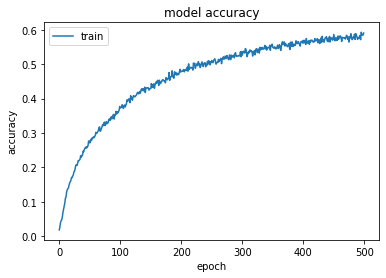

In [14]:
# plotting training accuracy

from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

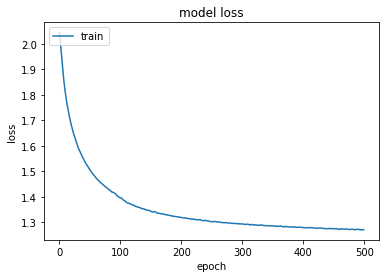

In [15]:
# plotting training loss

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [16]:
# time to test the recommendations for ingredients
input_text = ['basil leaves', 'pasta']

# converts text to vector
input_vector = [word2vec[idx] if idx in word2vec else np.zeros((100,)) for idx in input_text]
if len(input_vector)!=2:
  while len(input_vector)!=2:
    input_vector.append(np.zeros((100,)))

# converts input vector to numpy array
input_vector = np.array([input_vector])

# getting model predictions for top 10 suggestions by finding the 10 most similar ingredients to our output
output_vector = model.predict(input_vector)
pred = word2vec.most_similar(positive=[output_vector.reshape(100,)], topn=10)
print("Top 10 ingredient suggestions:")
pred

Top 10 ingredient suggestions:


[('olive oil spray', 0.32864615321159363),
 ('vegan', 0.3165924549102783),
 ('portabello mushroom', 0.31001338362693787),
 ('plum tomatoes', 0.30428123474121094),
 ('japanese eggplants', 0.2890123128890991),
 ('medium tomatoes', 0.28759557008743286),
 ('peeled tomatoes', 0.2813294529914856),
 ('yoghurt', 0.27990567684173584),
 ('black truffle oil', 0.2765144109725952),
 ('nutritional yeast', 0.2738874852657318)]